In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## Modelisation of the strategies

In [100]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %I-%p')
    
data = pd.read_csv("data/Kraken_BTCEUR_1h.csv", skiprows = [0], parse_dates=['Date'], date_parser = dateparse)

#columns with lower case.
data.columns = [column.lower() for column in data.columns]

data = data[(data['date'] > "2019-01-01") & (data['date'] < pd.to_datetime("2020-06-20"))]

#Reverse the dataframe.
data = data[::-1]

data.reset_index(inplace = True, drop = True)

In [121]:
#One have 'eur_available' and want to invest 'monthly_investment' every month, from 'date_start' to 'date_stop'. 
#The historical data can be found in 'data_path' and the profit_target (for instance 1.02 for 2% of profit) is 'expected_profit'
def crypto_investment(data_path, eur_available, monthly_investment, expected_profit, date_start = "2019-01-01", date_stop = "2020-01-31"):
    
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %I-%p')
    
    data = pd.read_csv(data_path, skiprows = [0], parse_dates=['Date'], date_parser = dateparse)
    
    #columns with lower case.
    data.columns = [column.lower() for column in data.columns]
    
    data = data[(data['date'] > date_start) & (data['date'] < pd.to_datetime("2020-05-01"))]
    
    #Reverse the dataframe.
    data = data[::-1]
    
    data.reset_index(inplace = True, drop = True)
    
    #The money is invest on a weekly basis.
    week_placement = monthly_investment/4.5
    
    balance_crypto = 0
    
    #Each order (buy or sale) will be record in the transactions dataframe.
    #The threshold is the price at which the coins would be sold.
    transactions_columns = ["order", "date", "crypto_price", "crypto_quantity", "threshold", "is_sold", "balance_eur", "balance_crypto", "id_sold"]
    
    transactions = pd.DataFrame(columns = transactions_columns)
    
    transactions.loc[0, "balance_eur"] = eur_available
    
    transactions.loc[0, "balance_crypto"] = balance_crypto
    
    #The historical data is hourly. i iterates through the hours...
    
    for i in data.index[1:]:
    
        crypto_price = data.loc[i,"close"]

        date = data.loc[i,"date"]

        #Buy the crypto
        #Every sunday at 7am, week_placement (in eur) are exchange in crypto.
        if (date.weekday() == 6) & (date.hour == 7) & (date <= pd.to_datetime(date_stop)) :

            crypto_quantity = week_placement / crypto_price
            
            #the crypto_quantity will be sold as soon as the crypto price will reach the threshold.
            threshold = crypto_price * expected_profit

            new_balance_eur = transactions.iloc[-1]["balance_eur"] - week_placement

            new_balance_crypto = transactions.iloc[-1]["balance_crypto"] + crypto_quantity

            new_transaction = ["buy", date, crypto_price, crypto_quantity, threshold, False, new_balance_eur, new_balance_crypto, np.nan]

            transactions = transactions.append(dict(zip(transactions_columns, new_transaction)), ignore_index = True)

        #If the crypto_price hit a threshold, some coins are sold. to_sell is a dataframe with the coins to sell.
        to_sell = transactions[(transactions["threshold"] < crypto_price) & (transactions["is_sold"] == False ) & (transactions["order"] == "buy" )]

        idx_to_sell = to_sell.index
        
        #If they are crypto to sell:
        if len(idx_to_sell) > 0:

            for j in idx_to_sell:

                crypto_quantity = to_sell.loc[j, "crypto_quantity"]

                #Fees for selling are fixed to 1%.
                revenues = crypto_quantity * crypto_price * 0.99

                transactions.loc[j, "is_sold"] = True

                new_balance_eur = transactions.iloc[-1]['balance_eur'] + revenues

                new_balance_crypto = transactions.iloc[-1]['balance_crypto'] - crypto_quantity

                threshold = to_sell.loc[j,"threshold"]
                
                date_buy = to_sell.loc[j,"date"]

                new_transaction = ["sold", date, crypto_price, crypto_quantity, threshold, np.nan, new_balance_eur, new_balance_crypto, j]

                transactions = transactions.append(dict(zip(transactions_columns, new_transaction)), ignore_index = True)
            
    return transactions 

In [122]:
#Compute the number of days between the buy and the sale.
def days_between_buy_and_sell(df):
    
    df['delta_buy_sell'] = np.nan
    
    for i in df.index:
        
        if df['id_sold'].loc[i] == df['id_sold'].loc[i]:
            
            delta = df['date'].loc[i] - df['date'].loc[df['id_sold'].loc[i]] 
            
            delta = delta.days
            
            df.loc[i,'delta_buy_sell'] = delta
            
    return df

In [123]:
#sold all the coins at the "date". The exchange rate of the "date" is used.
def sell_all(data_path ,transactions, date = "2020-06-20"):
    
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %I-%p')
    
    data = pd.read_csv(data_path, skiprows = [0], parse_dates=['Date'], date_parser = dateparse)
    
    #columns with lower case.
    data.columns = [column.lower() for column in data.columns]
    
    data = data[::-1]
    
    data.reset_index(inplace = True, drop = True)
    
    transactions_columns = transactions.columns
    
    date = pd.to_datetime(date)
    
    crypto_price = data[data["date"] == date]['close'].values[0]
    
    df_unsold = transactions[transactions['is_sold'] == False]
    
    crypto_quantity = sum(df_unsold["crypto_quantity"])

    #Fees of 1%
    revenues = crypto_quantity * crypto_price * 0.99

    new_balance_eur = transactions.iloc[-1]['balance_eur'] + revenues

    new_balance_crypto = transactions.iloc[-1]['balance_crypto'] - crypto_quantity

    new_entry = ["sold", date, crypto_price, crypto_quantity, np.nan, np.nan, new_balance_eur, new_balance_crypto,  np.nan]

    transactions = transactions.append(dict(zip(transactions_columns, new_entry)), ignore_index = True)
    
    return transactions

In [124]:
#Re_sample the data frame per minute. 
def re_sample(transactions):
    
    transactions = transactions.reset_index(drop = True)
    
    #transactions = transactions.sort_values(by = "Date", na_position = 'first')
    for i in transactions.index[0:-1]:
        
        date = transactions.loc[i, "date"]
        
        if sum(transactions["date"] == date) > 1:
            
            for j in range(sum(transactions["date"] == date)):
                
                transactions.loc[i + j, "date"] += dt.timedelta(minutes = j)
    
    transactions = transactions.iloc[1:]
    
    transactions.index = transactions['date']

    transactions1 = transactions[['balance_eur', 'balance_crypto', 'date']].resample('T').pad()
    
    transactions2 = transactions.drop(columns = ['balance_eur', 'balance_crypto']).resample('T').asfreq()
    
    transactions = pd.concat([transactions1.drop(columns = 'date'), transactions2], axis=1, join='inner')                        
    
    transactions.rename(columns = {"date" : "date_real"}, inplace = True)
    
    new_transactions = transactions.copy()
    
    return new_transactions

In [125]:
#Compute the maximum return on investment if all the coins are sold at their 'threshold' value.
def maximum_earning(transactions):
    
    crypto_prices = transactions[transactions['is_sold'] == False]['crypto_price'].values
    
    crypto_quantities = transactions[transactions['is_sold'] == False]['crypto_quantity'].values
    
    cost = np.matmul(crypto_prices, crypto_quantities)
    
    threshold = transactions[transactions['order'] == 'buy']['threshold'].iloc[1] / transactions[transactions['order'] == 'buy']['crypto_price'].iloc[1]
    
    maximum_earning = cost * threshold
    
    return maximum_earning, threshold

In [147]:
#hist of the number of days before selling a coin at a threshold price.
def hist_day_to_sell(transactions):
    
    max_earning, threshold = maximum_earning(transactions)
    
    transactions['delta_buy_sell'].plot(kind = 'hist', bins = 30,figsize = (20,10), grid = True)
    
    plt.title("Number of days before selling the coins at +{}% ".format(round((threshold - 1) * 100, 0)))
    
    plt.xlabel("Days")
    
    plt.ylabel("Count")
    
    plt.show()

    sale_all_revenues = transactions.iloc[-1]['balance_eur'] - transactions.iloc[-2]['balance_eur']

    opportunity_cost = max_earning - sale_all_revenues

    print(sum(transactions['is_sold'] == False), "'week placement' have been sold at the end.")

    print("If one would have wait the crypto to hit the threshold, one would have make extra €", int(opportunity_cost))
    

In [140]:
def plot_strategies(data_path, transactions_dict, crypto_price = False):
    
    #Read the historical data
    data = pd.read_csv(data_path, skiprows = [0], parse_dates=['Date'], date_parser = dateparse)
    #columns with lower case.
    data.columns = [column.lower() for column in data.columns]
    data = data[(data['date'] > "2019-01-01") & (data['date'] < pd.to_datetime("2020-06-20"))]
    #Reverse the dataframe.
    data = data[::-1]
    data.reset_index(inplace = True, drop = True)
    data_date_formated = [date.date() for date in data["date"]]

    fig, ax1 = plt.subplots(figsize=(20,10))
    plt.xlabel('Days')
    plt.ylabel('balance in €')
    plt.title("Balance in € for 3 different strategies")

    #ax1.plot(dates_formated[0], transactions_dict[0]['balance_eur'], label = 'Balance € with threshold 1%')
    ax1.plot(dates_formated[1], transactions_dict[1]['balance_eur'], label = 'Balance € with a profit of 5%')
    ax1.plot(dates_formated[2], transactions_dict[2]['balance_eur'], label = 'Balance € with a profit of 10%')
    ax1.plot(dates_formated[3], transactions_dict[3]['balance_eur'], label = 'Balance € with a profit of 15%')

    #Annotation stop buying
    plt.axvline(pd.to_datetime("2019-12-31"), color = 'r')
    ax1.annotate('We stop buying cryptocurrency weekly',
                xy=(pd.to_datetime("2019-12-28"), 10100),  # theta, radius
                xytext=(0.55, 0.85),    # fraction, fraction
                textcoords='figure fraction',
                arrowprops=dict(facecolor='red', shrink=0.03),
                horizontalalignment='left',
                verticalalignment='bottom')

    #Annotation sell all
    plt.axvline(pd.to_datetime("2020-02-28"), color = 'r')
    ax1.annotate('All the crypto are sold',
                xy=(pd.to_datetime("2020-03-3"), 11000),  # theta, radius
                xytext=(0.9, 0.90),    # fraction, fraction
                textcoords='figure fraction',
                arrowprops=dict(facecolor='red', shrink=0.03),
                horizontalalignment='left',
                verticalalignment='bottom')

    if crypto_price: 
        ax2 = ax1.twinx()
        color = 'm'
        ax2.set_ylabel("Crypto price", color = color)
        ax2.plot(data_date_formated, data['close'])
        ax2.tick_params(axis='y', labelcolor=color)

    plt.legend(loc="upper left")
    plt.show()
    print("Balance in € after selling all the coins with strategy blue the 1st May 2020: ", int(transactions_dict[0]['balance_eur'].iloc[-1]))
    print("Balance in € after selling all the coins with strategy yellow the 1st May 2020: ", int(transactions_dict[1]['balance_eur'].iloc[-1]))
    print("Balance in € after selling all the coins with strategy green the 1st May 2020: ", int(transactions_dict[2]['balance_eur'].iloc[-1]))
    #print("Balance € after selling all the coins with strategy red: ", int(transactions_dict[3]['balance_eur'].iloc[-1]))

    #print("______________________________________________________________________")
    #print("A sum of € ", sum(transaction[0]['Order'] == 'Buy') * 222, " has been invested")

## BTC Modelisation

In [159]:
#Let's analyse the return of this strategy by buying Bitcoins. 
#Profit of 1%, 5%, 10%, 15% and 20% are targeted.

field = ["data_path", "eur_available", "monthly_investment", "expected_profit", "date_stop"]
parameters = dict()

parameters[0] = ["data/Kraken_BTCEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]
parameters[1] = ["data/Kraken_BTCEUR_1h.csv", 10000, 1000, 1.05, "2020-01-01"]
parameters[2] = ["data/Kraken_BTCEUR_1h.csv", 10000, 1000, 1.1, "2020-01-01"]
parameters[3] = ["data/Kraken_BTCEUR_1h.csv", 10000, 1000, 1.15, "2020-01-01"]

parameters[0] = dict(zip(field, parameters[0]))
parameters[1] = dict(zip(field, parameters[1]))
parameters[2] = dict(zip(field, parameters[2]))
parameters[3] = dict(zip(field, parameters[3]))

transactions_dict = dict()
dates_formated = dict()

In [129]:
for i in range(4):
    transactions_dict[i] = crypto_investment(**parameters[i])
    transactions_dict[i] = days_between_buy_and_sell(transactions_dict[i])
    transactions_dict[i] = sell_all("data/Kraken_BTCEUR_1h.csv", transactions_dict[i], "2020-03-01")
    transactions_dict[i] = re_sample(transactions_dict[i])
    dates_formated[i] = [date.date() for date in transactions_dict[i].index]

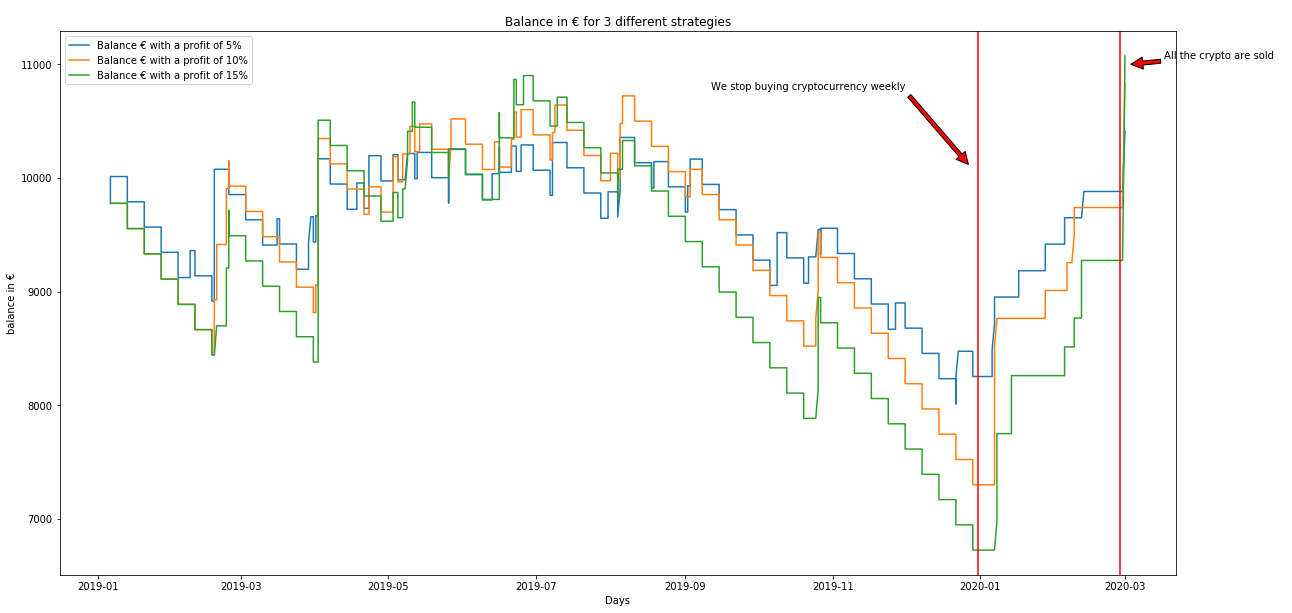

Balance in € after selling all the coins with strategy blue the 1st May 2020:  10039
Balance in € after selling all the coins with strategy yellow the 1st May 2020:  10411
Balance in € after selling all the coins with strategy green the 1st May 2020:  10830


In [141]:
plot_strategies("data/Kraken_BTCEUR_1h.csv", transactions_dict)

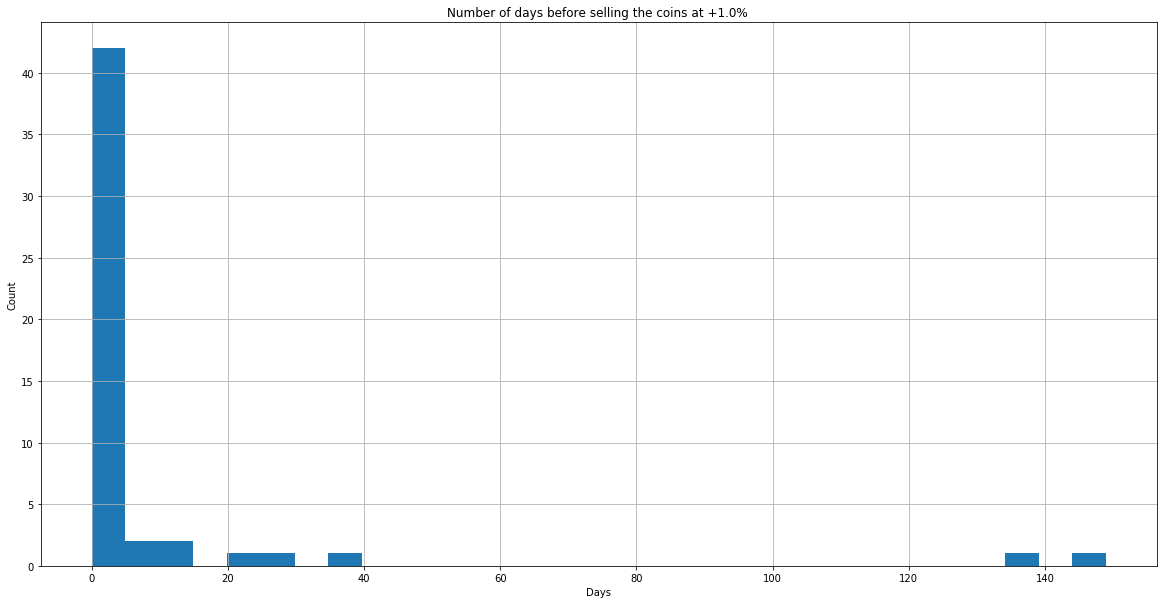

1 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 46


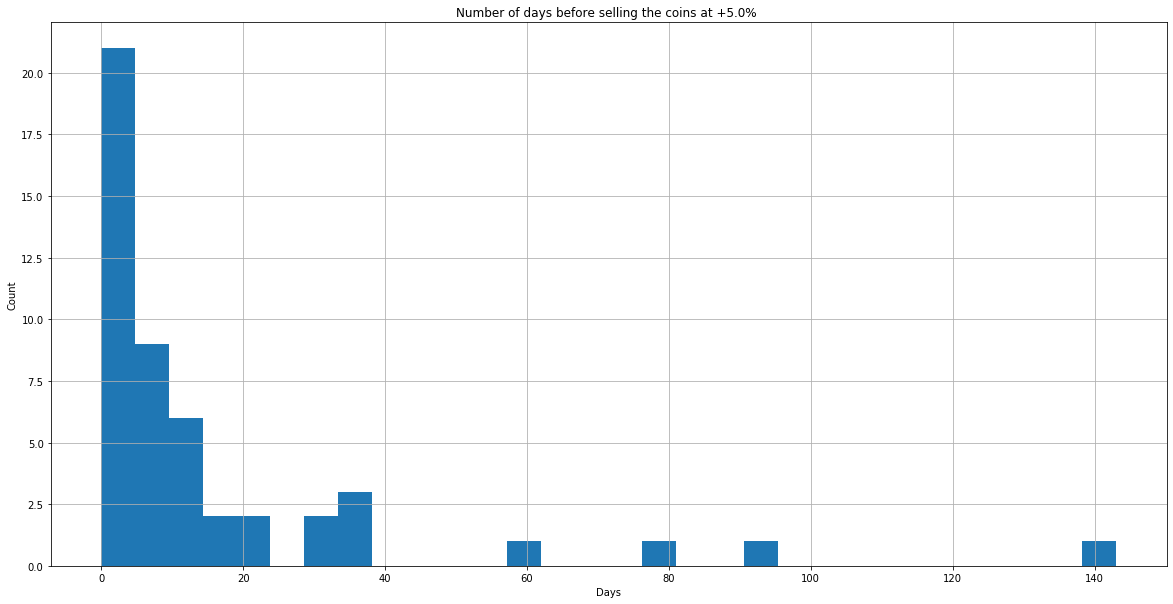

3 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 170


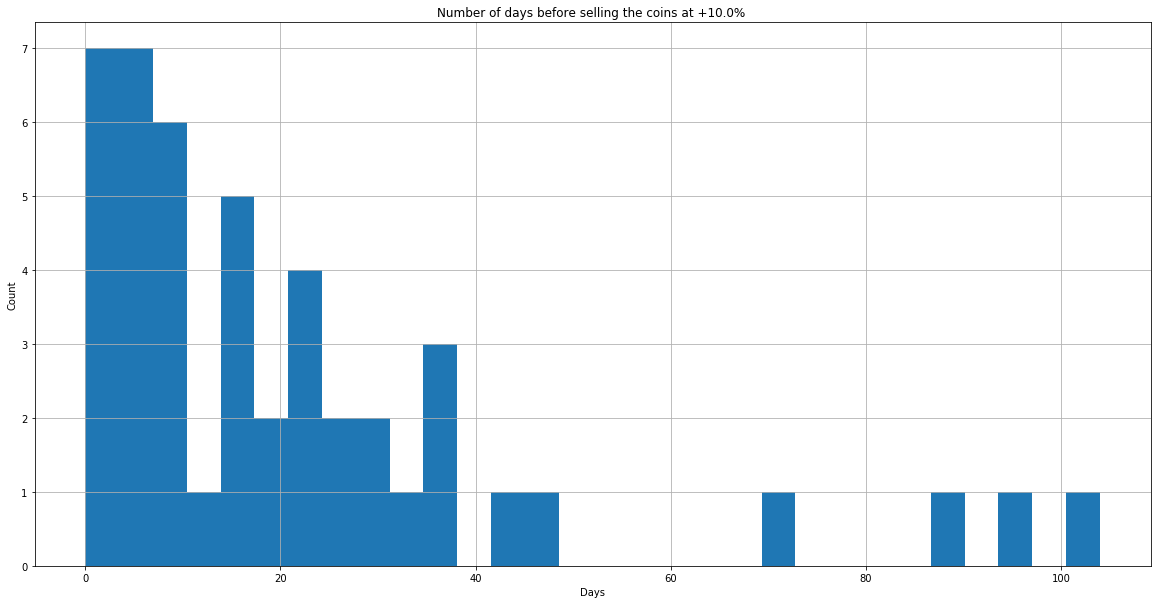

6 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 376


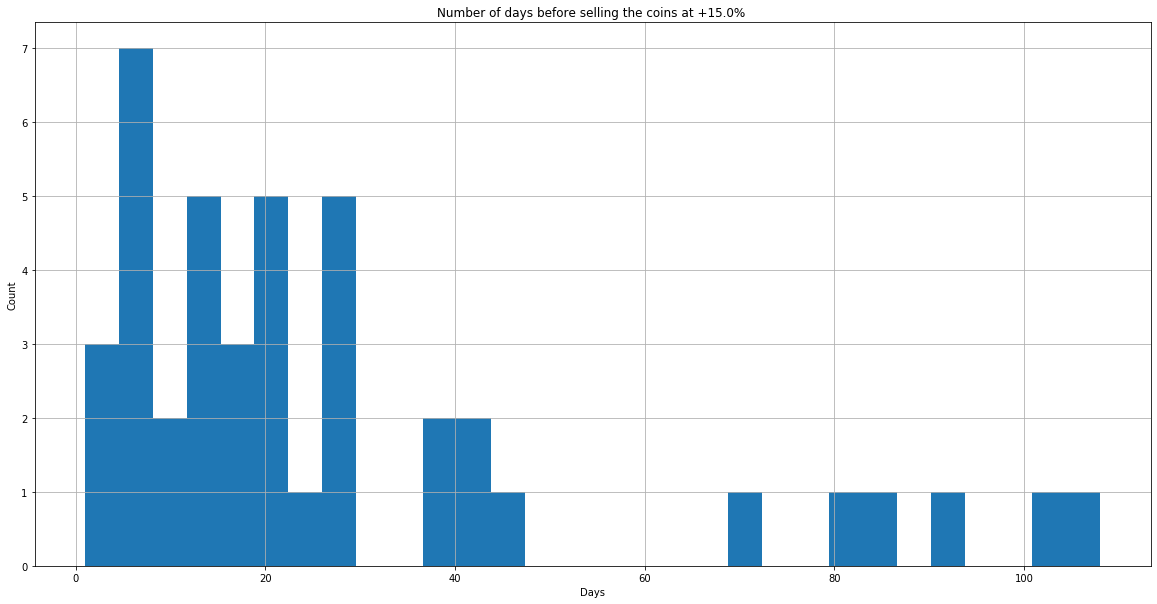

10 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 756


In [149]:
for i in range(4):
    hist_day_to_sell(transactions_dict[i])

## ETH modelisation

In [150]:
#Let's analyse the return of this strategy by buying ETH. 
#Profit of 1%, 5%, 10%, 15% and 20% are targeted.

field = ["data_path", "eur_available", "monthly_investment", "expected_profit", "date_stop"]
parameters = dict()

parameters[0] = ["data/Kraken_ETHEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]
parameters[1] = ["data/Kraken_ETHEUR_1h.csv", 10000, 1000, 1.05, "2020-01-01"]
parameters[2] = ["data/Kraken_ETHEUR_1h.csv", 10000, 1000, 1.1, "2020-01-01"]
parameters[3] = ["data/Kraken_ETHEUR_1h.csv", 10000, 1000, 1.15, "2020-01-01"]

parameters[0] = dict(zip(field, parameters[0]))
parameters[1] = dict(zip(field, parameters[1]))
parameters[2] = dict(zip(field, parameters[2]))
parameters[3] = dict(zip(field, parameters[3]))

transactions_dict = dict()
dates_formated = dict()

In [151]:
for i in range(4):
    transactions_dict[i] = crypto_investment(**parameters[i])
    transactions_dict[i] = days_between_buy_and_sell(transactions_dict[i])
    transactions_dict[i] = sell_all("data/Kraken_ETHEUR_1h.csv", transactions_dict[i], "2020-03-01")
    transactions_dict[i] = re_sample(transactions_dict[i])
    dates_formated[i] = [date.date() for date in transactions_dict[i].index]

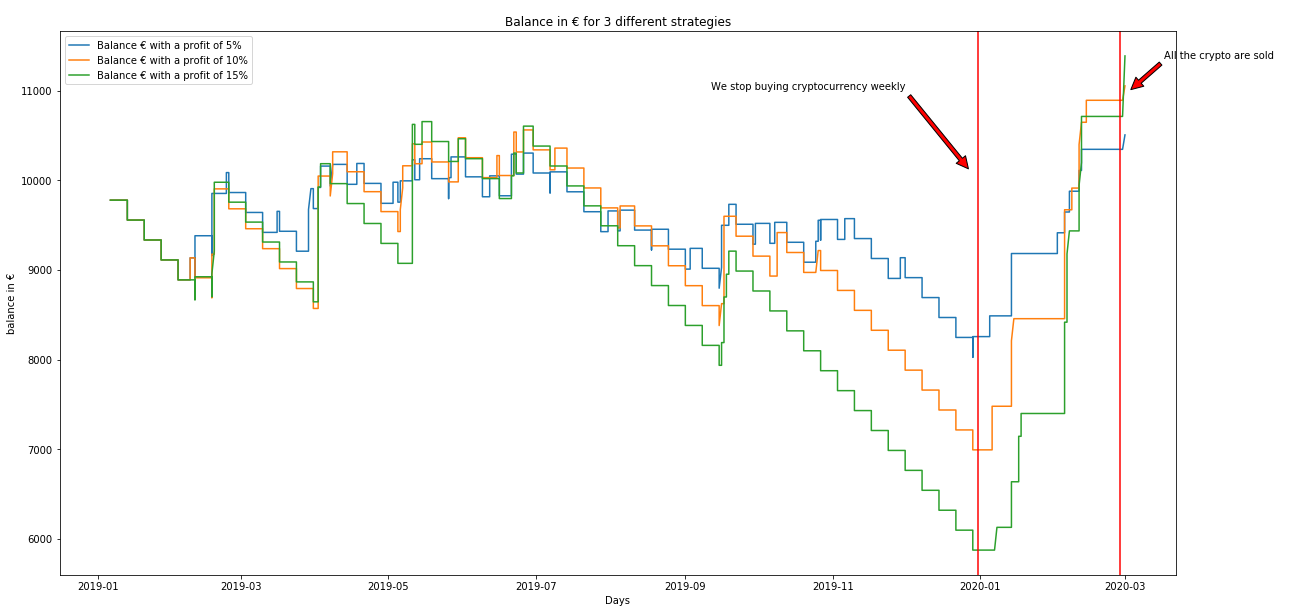

Balance in € after selling all the coins with strategy blue the 1st May 2020:  10070
Balance in € after selling all the coins with strategy yellow the 1st May 2020:  10505
Balance in € after selling all the coins with strategy green the 1st May 2020:  11051


In [152]:
plot_strategies("data/Kraken_ETHEUR_1h.csv", transactions_dict)

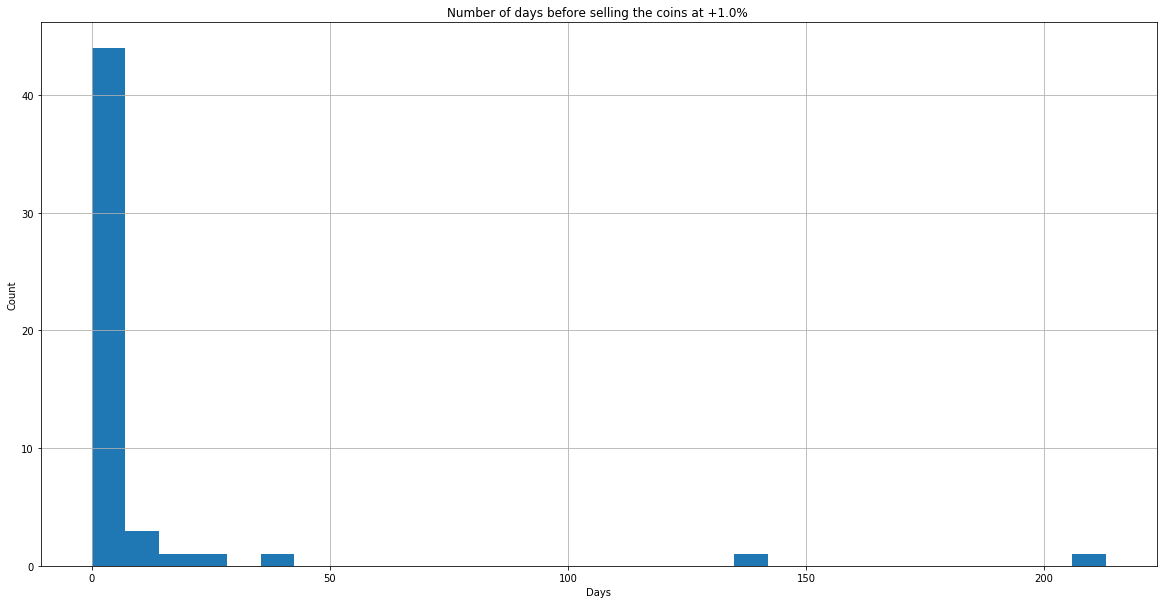

0 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 0


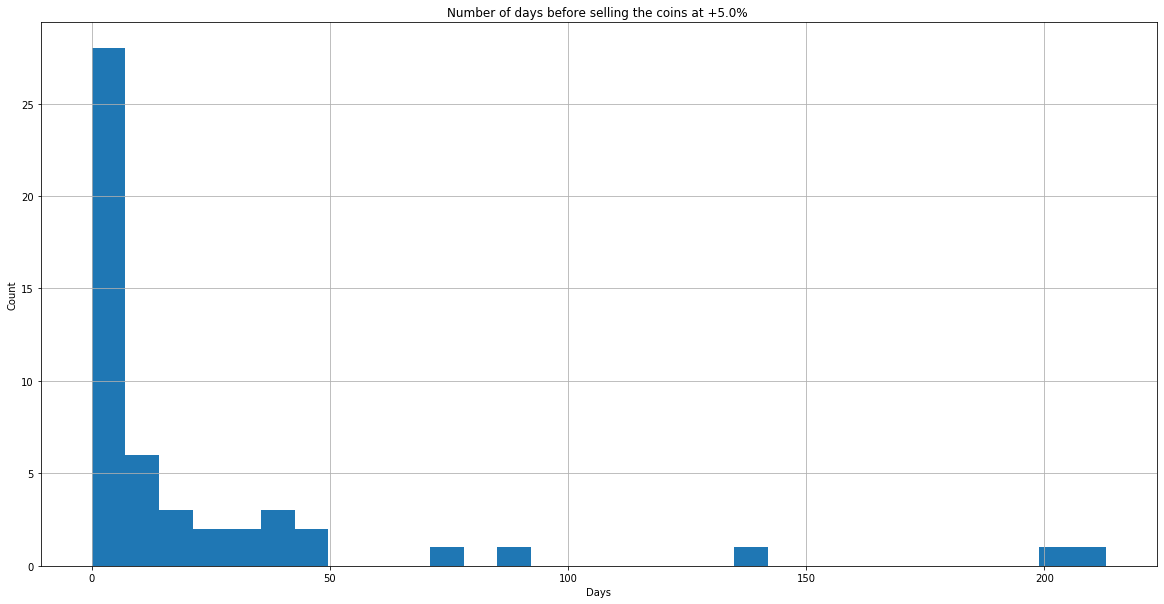

1 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 72


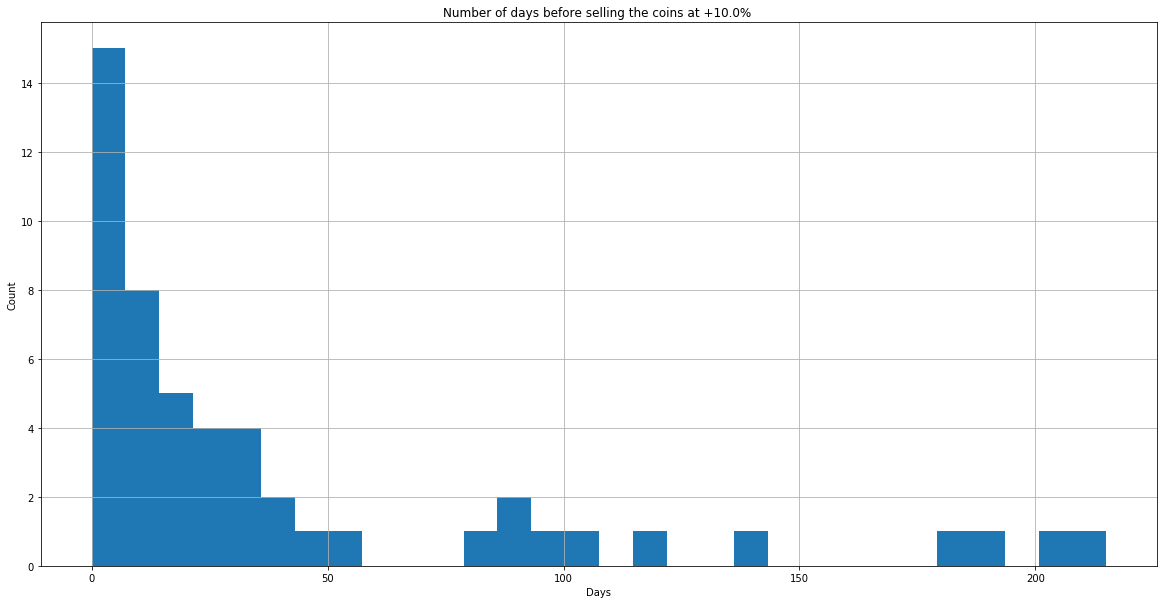

1 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 83


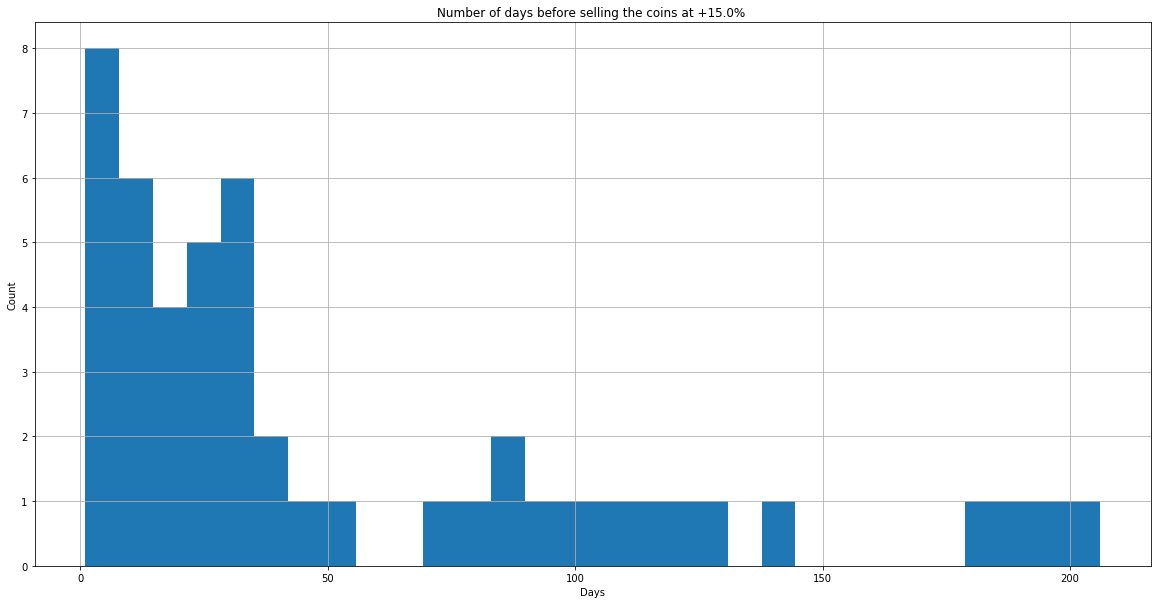

4 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 347


In [154]:
for i in range(4):
    hist_day_to_sell(transactions_dict[i])

## LTC modelisation

In [155]:
#Let's analyse the return of this strategy by buying ETH. 
#Profit of 1%, 5%, 10%, 15% and 20% are targeted.

field = ["data_path", "eur_available", "monthly_investment", "expected_profit", "date_stop"]
parameters = dict()

parameters[0] = ["data/Kraken_LTCEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]
parameters[1] = ["data/Kraken_LTCEUR_1h.csv", 10000, 1000, 1.05, "2020-01-01"]
parameters[2] = ["data/Kraken_LTCEUR_1h.csv", 10000, 1000, 1.1, "2020-01-01"]
parameters[3] = ["data/Kraken_LTCEUR_1h.csv", 10000, 1000, 1.15, "2020-01-01"]

parameters[0] = dict(zip(field, parameters[0]))
parameters[1] = dict(zip(field, parameters[1]))
parameters[2] = dict(zip(field, parameters[2]))
parameters[3] = dict(zip(field, parameters[3]))

transactions_dict = dict()
dates_formated = dict()

In [156]:
for i in range(4):
    transactions_dict[i] = crypto_investment(**parameters[i])
    transactions_dict[i] = days_between_buy_and_sell(transactions_dict[i])
    transactions_dict[i] = sell_all("data/Kraken_LTCEUR_1h.csv", transactions_dict[i], "2020-03-01")
    transactions_dict[i] = re_sample(transactions_dict[i])
    dates_formated[i] = [date.date() for date in transactions_dict[i].index]

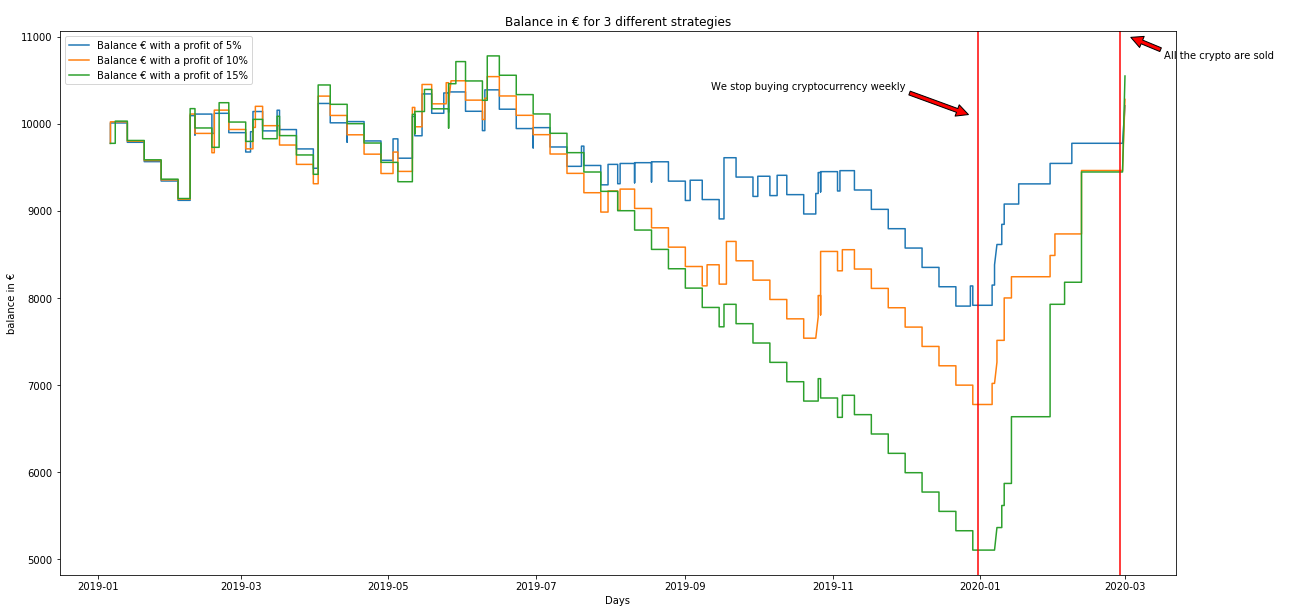

Balance in € after selling all the coins with strategy blue the 1st May 2020:  9957
Balance in € after selling all the coins with strategy yellow the 1st May 2020:  10209
Balance in € after selling all the coins with strategy green the 1st May 2020:  10282


In [158]:
plot_strategies("data/Kraken_LTCEUR_1h.csv", transactions_dict)

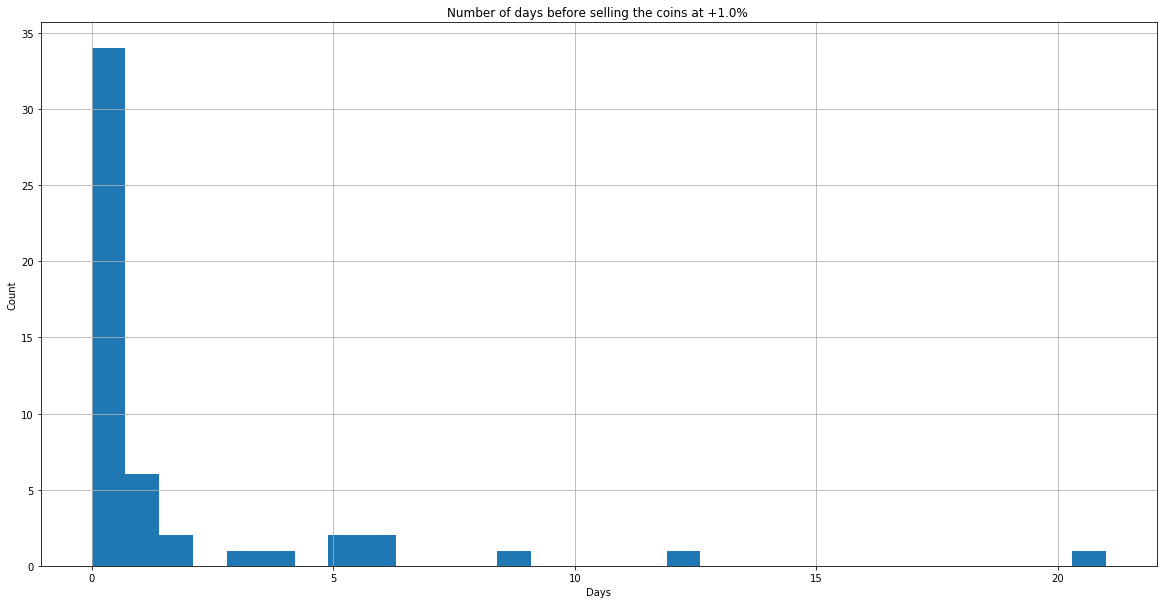

1 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 130


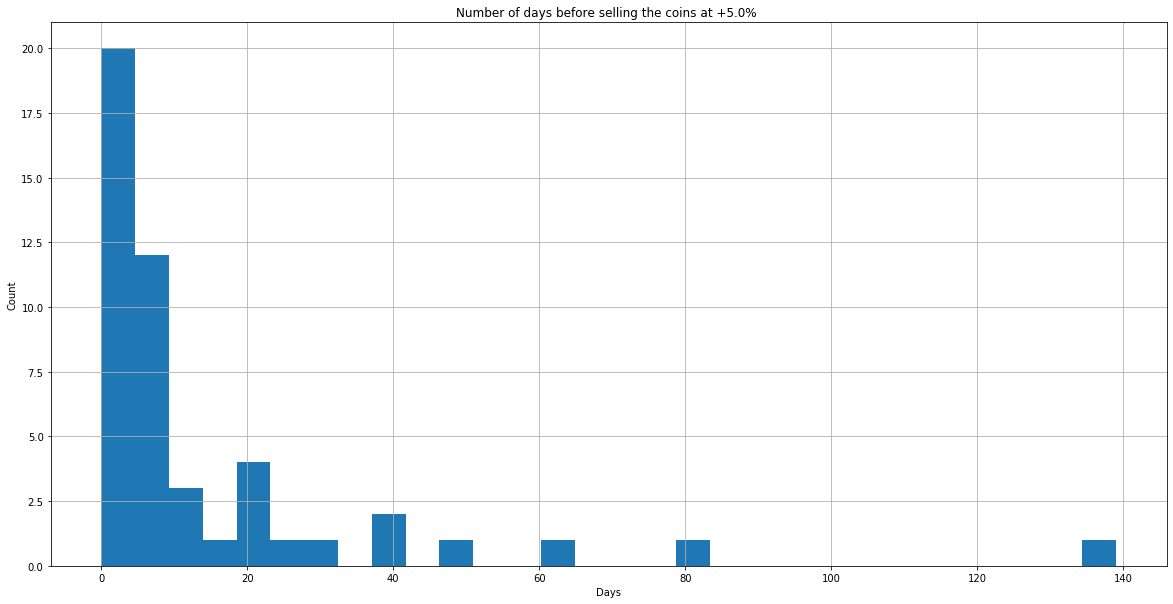

4 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 502


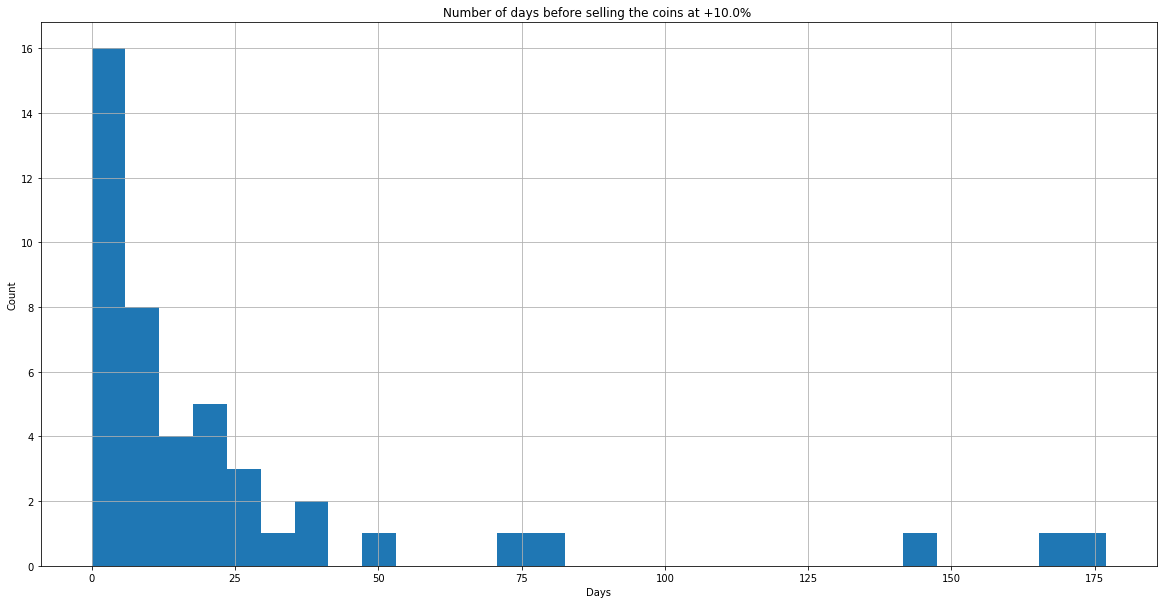

7 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 894


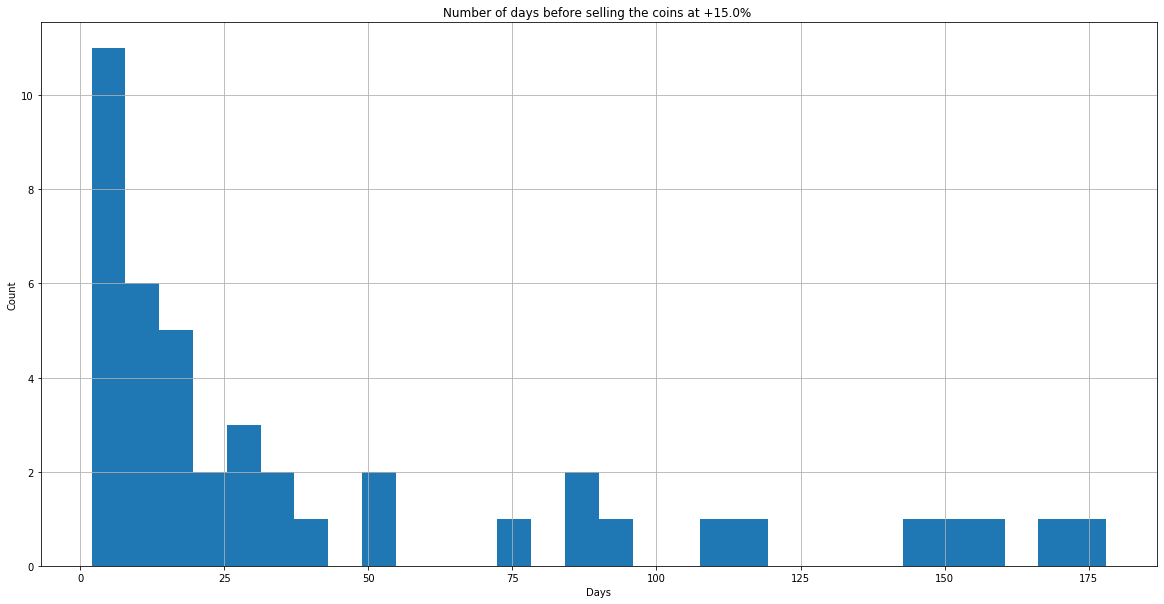

9 'week placement' have been sold at the end.
If one would have wait the crypto to hit the threshold, one would have make extra € 1197


In [157]:
for i in range(4):
    hist_day_to_sell(transactions_dict[i])

## Comparison of the coins for exchange currency for free

In [161]:
#1) One can buy coin in currency 1
#2) Wait that the coins value increase by 1% (to pay back the transaction fees)
#3) Sell the coin in currency 2

In [166]:
coins = ['btc', 'eth', 'ltc']

parameters = dict()
parameters['btc'] = ["data/Kraken_BTCEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]
parameters['eth']= ["data/Kraken_ETHEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]
parameters['ltc'] = ["data/Kraken_LTCEUR_1h.csv", 10000, 1000, 1.01, "2020-01-01"]

parameters['btc'] = dict(zip(field, parameters['btc']))
parameters['eth'] = dict(zip(field, parameters['eth']))
parameters['ltc'] = dict(zip(field, parameters['ltc']))

transactions_dict = dict()
dates_formated = dict()

In [167]:
for coin in coins:
    transactions_dict[coin] = crypto_investment(**parameters[coin])
    transactions_dict[coin] = days_between_buy_and_sell(transactions_dict[coin])
    transactions_dict[coin] = sell_all("data/Kraken_ETHEUR_1h.csv", transactions_dict[coin], "2020-03-01")
    transactions_dict[coin] = re_sample(transactions_dict[coin])
    dates_formated[coin] = [date.date() for date in transactions_dict[coin].index]

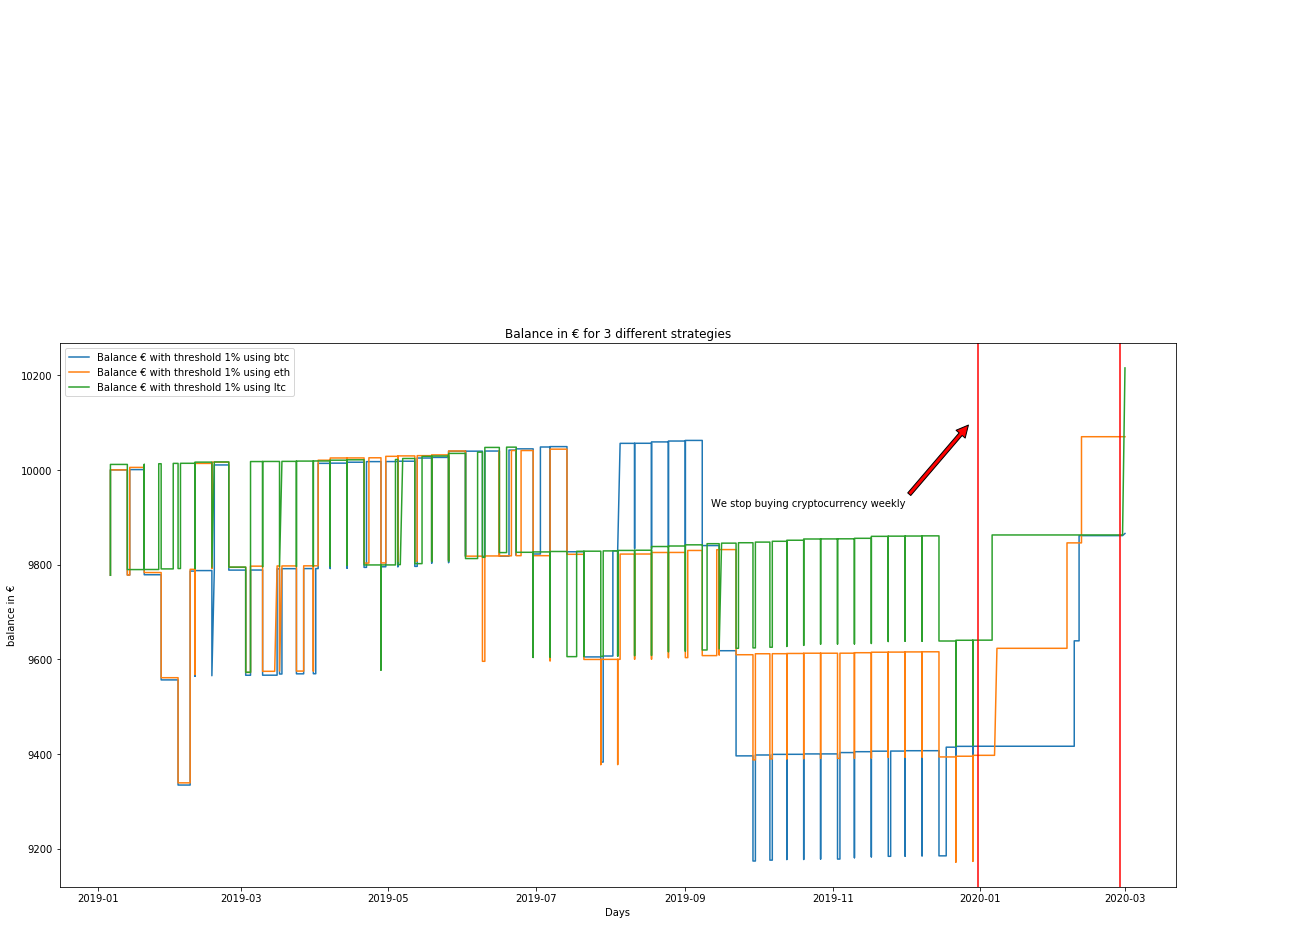

Balance in € after selling all the btc with strategy blue the 1st May 2020:  9866
Balance in € after selling all the eth with strategy yellow the 1st May 2020:  10070
Balance in € after selling all the ltc with strategy green the 1st May 2020:  10215


In [171]:
#Read the historical data
fig, ax1 = plt.subplots(figsize=(20,10))
plt.xlabel('Days')
plt.ylabel('balance in €')
plt.title("Balance in € for 3 different strategies")

ax1.plot(dates_formated["btc"], transactions_dict["btc"]['balance_eur'], label = 'Balance € with threshold 1% using btc')
ax1.plot(dates_formated["eth"], transactions_dict["eth"]['balance_eur'], label = 'Balance € with threshold 1% using eth')
ax1.plot(dates_formated["ltc"], transactions_dict["ltc"]['balance_eur'], label = 'Balance € with threshold 1% using ltc')

#Annotation stop buying
plt.axvline(pd.to_datetime("2019-12-31"), color = 'r')
ax1.annotate('We stop buying cryptocurrency weekly',
            xy=(pd.to_datetime("2019-12-28"), 10100),  
            xytext=(0.55, 0.45),    # fraction, fraction
            textcoords='figure fraction',
            arrowprops=dict(facecolor='red', shrink=0.03),
            horizontalalignment='left',
            verticalalignment='bottom')

#Annotation sell all
plt.axvline(pd.to_datetime("2020-02-28"), color = 'r')
ax1.annotate('All the crypto are sold',
            xy=(pd.to_datetime("2020-03-3"), 11000),  
            xytext=(0.9, 0.90),    # fraction, fraction
            textcoords='figure fraction',
            arrowprops=dict(facecolor='red', shrink=0.03),
            horizontalalignment='left',
            verticalalignment='bottom')

plt.legend(loc="upper left")
plt.show()
print("Balance in € after selling all the btc with strategy blue the 1st May 2020: ", int(transactions_dict["btc"]['balance_eur'].iloc[-1]))
print("Balance in € after selling all the eth with strategy yellow the 1st May 2020: ", int(transactions_dict["eth"]['balance_eur'].iloc[-1]))
print("Balance in € after selling all the ltc with strategy green the 1st May 2020: ", int(transactions_dict["ltc"]['balance_eur'].iloc[-1]))
#print("Balance € after selling all the coins with strategy red: ", int(transactions_dict[3]['balance_eur'].iloc[-1]))

#print("______________________________________________________________________")
#print("A sum of € ", sum(transaction[0]['Order'] == 'Buy') * 222, " has been invested")